<a href="https://colab.research.google.com/github/zzaeyun/ESAA23_1/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_157to202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**> CHAPTER4 모델 훈련**

- 분류기가 어떻게 작동하는지 잘 이해하고 있으면 적절한 모델, 올바르 훈련 알고리즘, 작업에 맞는 좋은 하이퍼파라미터를 빠르게 찾을 수 있음
- 이는 신경망을 이해하고 구축하고 훈련시키는 데 필수

**선형 회귀 모델을 훈련시키는 두가지 방법**
- 직접 계산할 수 있는 공식을 사용하여 훈련 세트에 잘 맞는 모델 파라미터를 해석적으로 구함
- 경사 하강법(GD)이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화
  - 결국 앞의 방법과 동일한 파라미터로 수렴
  - 배치 경사 하강법, 미니배치 경사 하강법, 확률적 경사 하강법



---

##**4.1 선형 회귀**

선형 회귀 모델
- 삶의 만족도= a + b * (1인당_GDP)
- 이처럼 가중치 합과 편향(절편)이라는 상수를 더해 예측

- 모델을 훈련시키다는 것은 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터를 설정하는 것
  - RMSE를 최소화하는 파라미터를 찾기



---
###**4.1.1 정규 방정식**

**정규방정식**
- 비용 함수를 최소화하는 세타값을 찾기 위한 해석적인 방법




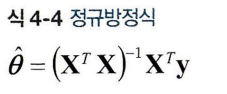

In [1]:
import numpy as np

X=2*np.random.rand(100,1)
y=4+3*X+np.random.randn(100,1)

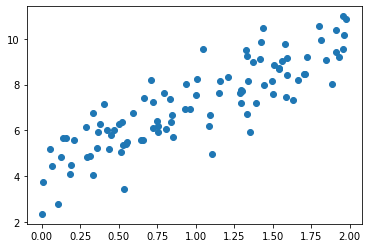

In [2]:
import matplotlib.pyplot as plt

plt.scatter(X,y)

넘파이 선형대수 모듈(np.linalg)에 있는 inv() 함수를 사용해 역행렬을 계산하고 dot() 메서드를 사용해 행렬 곱셈

In [3]:
X_b=np.c_[np.ones((100,1)), X]
theta_best=np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
print(theta_best)

[[4.35015831]
 [2.79728617]]


theta0=4, theta1=3 을 기대했으나 잡음 때문에 정확한 재현X

In [5]:
X_new=np.array([[0],[2]])
X_new_b=np.c_[np.ones((2,1)), X_new]
y_predict=X_new_b.dot(theta_best)
y_predict

array([[4.35015831],
       [9.94473065]])

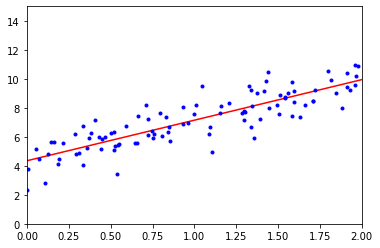

In [6]:
plt.plot(X_new, y_predict,'r-')
plt.plot(X,y,'b.')
plt.axis([0,2,0,15])
plt.show()

In [7]:
#사이킷런에서 선형 회귀 수행

from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X,y)
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.35015831] [[2.79728617]]
[[4.35015831]
 [9.94473065]]


- LinearRegression 클래스는 scipy.linalg.lstsq() 함수를 기반

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
print(theta_best_svd)

[[4.35015831]
 [2.79728617]]


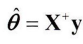

scipy.linalg.lstsq 함수는 위 식을 계산
- X+ 는 X의 유사역행렬
- np.linalg.pinv() 함수로 직접 유사역행렬을 구할 수 있음

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.35015831],
       [2.79728617]])

**유사역행렬**
- 특이값 분해 **(SVD)**라 부르는 표준 행렬 분해 기법을 사용해 계산
- 정규방정식을 계산하는 것보다 훨씬 효율적임
- 또한 극단적인 경우도 처리 가능



### **4.1.2 계산 복잡도**
- 역행렬을 계산하는 계산 복잡도는 O(n^2.4)에서 O(n^3)사이
- 특성 수가 두배로 늘어나면 계산 시간이 대략 2^2.4=5.3에서 2^3=8로 증가
- 사이킷런의 LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2)
  - 특성의 개수가 두 배로 늘어나면 계산 시간이 대략 4배

---

## **4.2 경사 하강법**

**경사 하강법(GD)**
- 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
- 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것
1. 파라미터 벡터 theta에 대해 비용 함수의 현재 그레이디언트 gradient를 계산
2. 그레이디언트가 감소하는 방향으로 진행
3. 그레이디언트가 0이 되면 최솟값에 도달한 것

- theta를 임의의 값으로 시작해서 (무작위 초기화) 한 번에 조금씩 비용 함수가 감소되는 방향으로 진행하여 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상


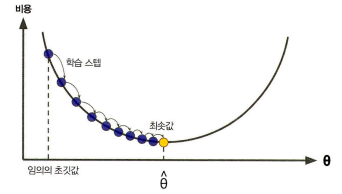

**학습률**
- 경사 하강법에서 중요한 파라미터로, 스텝의 크기를 나타냄
- 학습률이 너무 작으면 알고리즘이 수렴하기 위해 반복을 많이 진행해야 하므로 시간이 오래 걸림
- 학습률이 너무 크면 골짜기를 가로질러 반대편으로 건너뛰게 되어 이전보다 더 높은 곳으로 올라갈 수 있음

<br>

- 비용 함수는 특이한 지형이 있으면 최솟값으로 수렴하기 매우 어려움
- 무작위 초기화 때문에 알고리즘이 왼쪽에서 시작하면 **전역 최솟값**보다 덜 좋은 **지역 최솟값**에 수렴
 

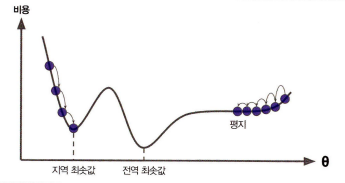

선형 회귀를 위한 MSE 비용 함수는 볼록 함수
- 지역 최솟값이 없고 하나의 전역 최솟값만 존재
- 연속된 함수이고 기울기가 급변하지 않음

**경사 하강법을 사용할 때에는 모든 특성이 같은 스케일을 갖도록**
- 스케일이 달라도 최솟값에 결국은 도달하겠지만 시간이 훨씬 오래 걸림

**파라미터 공간**
- 모델이 가진 파라미터가 많을수록 이 공간의 차원은 커지고 검색이 더 어려워짐


###**4.2.1 배치 경사 하강법**

- 경사 하강법을 구현하려면 각 모델 파라미터 theta에 대해 비용 함수의 그레이디언트를 계산해야 함
- **편도함수**: theta가 조금 변경될 때 비용 함수가 얼마나 바뀌는지


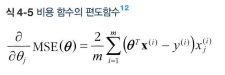

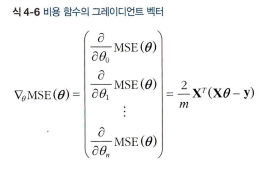

- 비용 함수의 편도함수를 모두 담고 있음

<br>

- 위로 향하는 그레이디언트 벡터가 구해지면 반대 방향인 아래로 가야함
  - theta에서 (그레이디언트 벡터)를 빼야 함

In [11]:
eta=0.1 #학습률
n_iterations=1000
m=100

theta= np.random.randn(2,1)

for iteration in range(n_iterations):
  gradients=2/m*X_b.T.dot(X_b.dot(theta)-y)
  theta=theta-eta*gradients

In [12]:
print(theta)

[[4.35015831]
 [2.79728617]]


- 적절한 학습률을 찾으려면 그리드 탐색을 사용
- 그리드 탐색에서 수렴하는 데 너무 오래 걸리는 모델을 막기 위해 반복 회수를 제한
  - 반복 회수가 너무 작으면 최적점에 도달하기 전에 알고리즘이 멈춤
  - 너무 크면 파라미터가 변하지 않는 동안 시간 낭비
- 반복 횟수를 아주 크게 지정하고 그레이디언트가 벡터가 아주 작아지면, 최솟값에 도달한 것이므로 알고리즘을 중지

<br>

### **4.2.2 확률적 경사 하강법**

**확률적 경사 하강법**
- 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트 계산
  - (배치 경사 하강법은 매 스텝 전체 훈련 세트 사용)
- 매 반복에서 다뤄야 할 데이터가 매우 적기 때문에 한 번에 하나의 샘플만 처리하면 알고리즘이 확실히 훨씬 빠름
- 반면 확률적이기 때문에 불안정, 최솟값에 다다를 때까지 위아래로 요동치면서 평균적으로 감소

<br>

- if 비용 함수가 매우 불규칙할 경우 알고리즘이 지역 최솟값을 건너뛸 수 있도록 도와주어 전역 최솟값을 찾을 가능성이 높음
  - 이처럼 지역 최솟값에서 탈출시켜주는 것은 좋지만 알고리즘을 전역 최솟값에 다다르지 못하게 한다는 점은 좋지 못함
- (해결) 학습률을 점진적으로 감소시키는 것
  - 담금질 기법 알고리즘과 유사
  

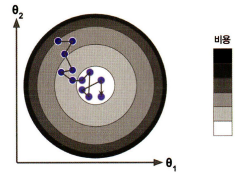

In [13]:
# 확률적 경사 하강법의 구현

n_epochs=50
t0, t1 = 5, 50

def learning_schedule(t):
  return t0/(t+t1)

theta=np.random.randn(2,1)

for epoch in range(n_epochs):
  for i in range(m):
    random_index=np.random.randint(m)
    xi=X_b[random_index:random_index+1]
    yi=y[random_index:random_index+1]
    gradients=2*xi.T.dot(xi.dot(theta)-yi)
    eta=learning_schedule(epoch*m+i)
    theta=theta-eta*gradients

- 에포크: 한 반복에서 m번 되풀이될 때 각 반복


In [14]:
print(theta)

[[4.37155669]
 [2.78436535]]


- 사이킷런에서 SGD 방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRegressor 클래스를 사용

<br> 

- max_iter=1000: 최대 1000번 에포크 동안 실행
- tol=1e-3: 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행
- eta0=0.1: 학습률 0.1로 기본 학습 스케줄 사용



In [16]:
from sklearn.linear_model import SGDRegressor

sgd_reg=SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [17]:
print(sgd_reg.intercept_, sgd_reg.coef_)

[4.32826151] [2.82537182]


### **4.2.3 미니배치 경사 하강법**

**미니배치 경사 하강법**
-  미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산
- 확률적 경사 하강법에 비해 미니배치 경사 하강법의 주요 ㅏㅇ점은 행렬 연산에 최적화된 하드웨어, 특히 GPU를 사용해서 얻는 성능 향상
- SGD보다 덜 불규칙하게 움직임
- 지역 최솟값에서 빠져나오기는 힘들 수 있음


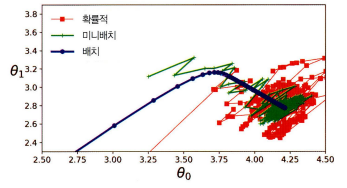

## **4.3 다항 회귀**

**다항 회귀**
- 비션형 데이터를 학습하는 데 선형모델을 사용
- 각 특성의 거듭제곱을 새로운 특성으로 추가하고 확장된 특성을 포함한 데이터셋에 선형 모델을 훈련


In [18]:
m=100
X=6*np.random.rand(m,1)-3
y=0.5*X**2 + X + 2 + np.random.randn(m,1)

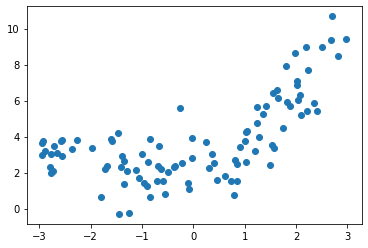

In [19]:
plt.scatter(X,y)

- 직선은 이 데이터에 잘맞지 않을 것
- 그러므로 사이킷런의 PolynomialFeatures를 사용해 훈련 데이터 변환
- 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가

In [20]:
from sklearn.preprocessing import PolynomialFeatures
poly_features =PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[2.22435153]
[2.22435153 4.94773971]


In [21]:
lin_reg=LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_, lin_reg.coef_

(array([2.35294579]), array([[0.97605494, 0.48919685]]))

- 특성이 여러 개일 때 다항 회귀는 이 특성 사이의 관계를 찾을 수 있음
- PolynomialFeatures가 주어진 차수까지 특성 간의 모든 교차항을 추가하기 때문


---

## **4.4 학습 곡선**

- 고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 할 것
  - 고차 다항 회귀 모델은 심각하게 훈련 데이터에 과대 적합
  - 선형 모델은 과소적합
- **학습 곡선**을 살펴보면 모델이 데이터에 과대적합 혹은 과소적합되었는지 알 수 있음
  - 학습 곡선: 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타냄
  

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range (1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth = 2, label = "train set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth = 3, label = "validation set") 
    plt.xlabel("size of train set")
    plt.ylabel("RMSE")
    plt.legend()

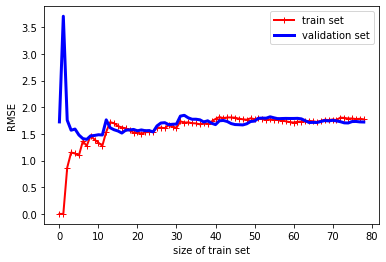

In [24]:
lin_reg=LinearRegression()
plot_learning_curves(lin_reg,X,y)

- 비선형이기 때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능
- 곡선이 어느 정도 평편해질 때까지 오차가 상승
- 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화될 수 없어서 검증 오차가 초기에 매우 큼
- 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소

<br>

- 10차 다항 회귀 모델의 학습 곡선 그려보기

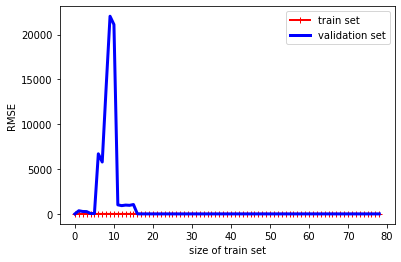

In [25]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression,X,y)

- 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮음
- 두 곡선 사이에 공간이 있음: 과대적합 모델의 특징
- 더 큰 훈련 세트를 사용하면 두 곡선이 점점 가까워짐

## **4.5 규제가 있는 선형 모델**

- 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것
- 자유도를 줄이면 데이터에 과대적합되기 더 어려워짐. 다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것

<br>

- 선형 회귀 모델에서는 보통 모델의 가중치를 제한함으로써 규제를 가함
  - 릿지
  - 라쏘
  - 엘라스틱넷

###**4.5.1 릿지 회귀**

**릿지 회귀 (티호노프 규제)**
- 규제가 추가된 선형 회귀 버전
- 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 노력
- 규제항은 훈련하는 동안에만 비용 함수에 추가
  - 모델의 훈련이 끝나면 모델의 성능을 규제가 없는 성능 지표로 평가

<br>

- 하이퍼파라미터 alpha는 모델을 얼마나 많이 규제할지 조절
  - alpha=0 : 선형회귀와 같아짐. 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선

- 릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터의 스케일을 맞추는 것이 중요
  - StandardScaler를 사용
  

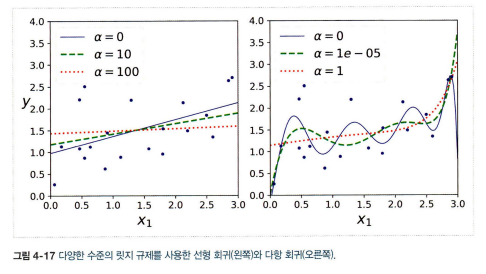

- alpha값을 조절하여 릿지 모델을 훈련시킨 결과
- alpha를 증가할수록 직선에 가까워짐
  - 모델의 분산은 줄지만 편향은 커짐

<br>

- 릿지 회귀 계산은 정규방정식, 경사 하강법 사용 가능


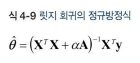

In [27]:
#사이킷런에서 정규 방정식을 사용한 릿지 회귀 적용

from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.03790518]])

In [29]:
#확률적 경사 하강법 사용

sgd_reg=SGDRegressor(penalty='l2')
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([5.04212341])

- l2는 SGD가 비용 함수에 가중치 벡터의 l2 노름의 제곱을 2로 나눈 규제항을 추가
: 릿지 회귀와 동일


---

###**4.5.2 라쏘 회귀**

- 가중치 벡터의 l1 노름을 사용


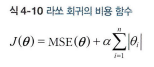

- **덜 중요한 특성의 가중치를 제거 (가중치가 0)**
- 자동으로 특성을 선택하고 희소 모델(sparse model)을 만듬

In [30]:
#사이킷런 Lasso 클래스

from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([4.98972117])

###**4.5.3 엘라스틱넷**

**엘라스틱넷**
- 릿지 회귀와 라쏘 회귀를 절충한 모델
- 규제항은 릿지와 회귀의 규제항을 단순히 더해서 사용
- 혼합 비율 r을 사용해 조절
  - r=0: 릿지 회귀와 동일
  - r=1: 라쏘 회귀와 동일

- 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 라쏘가 문제를 일으키므로 엘라스틱넷을 선호

In [31]:
# 사이킷런의 ElasticNet

from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.99444837])

###**4.5.4 조기 종료**

**조기 종료**
- 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것
  - 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훔련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어듬
  - 감소하던 검증 에러가 멈추었다가 다시 상승: 과대적합이 시작하는 것을 의미
  - 검증 에러가 최소에 도달하면 즉시 훈련을 멈추는 것

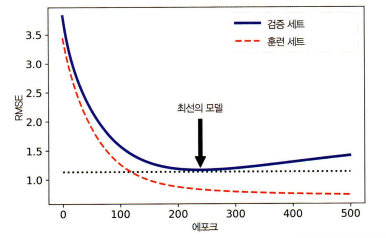

In [37]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

#why error?
'''
#데이터 준비
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter = 1, tol=-np.infty, warm_start = True,
                      penalty=None, learning_rate = "constant", eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)
        '''

'\n#데이터 준비\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)\npoly_scaler = Pipeline([\n    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),\n    ("std_scaler", StandardScaler())\n])\n\nX_train_poly_scaled = poly_scaler.fit_transform(X_train)\nX_val_poly_scaled = poly_scaler.fit_transform(X_val)\n\nsgd_reg = SGDRegressor(max_iter = 1, tol=-np.infty, warm_start = True,\n                      penalty=None, learning_rate = "constant", eta0=0.0005)\n\nminimum_val_error = float("inf")\nbest_epoch = None\nbest_model = None\nfor epoch in range(1000):\n    sgd_reg.fit(X_train_poly_scaled, y_train)\n    y_val_predict = sgd_reg.predict(X_val_poly_scaled)\n    val_error = mean_squared_error(y_val, y_val_predict)\n    \n    if val_error < minimum_val_error:\n        minimum_val_error = val_error\n        best_epoch = epoch\n        best_model = clone(sgd_reg)\n        '

##**4.6 로지스틱 회귀**

- 로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는 데 사용
  - 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측
  - 아니면 클래스에 속하지 않는다고 예측
  - **=> 이진 분류기**

<br>

###**4.6.1 확률 추정**
- 로지스틱 회귀 모델은 입력 트성의 가중치 합을 계산
- 대신 결괏값의 로지스틱을 출력



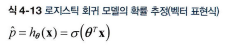

- 로지스틱은 0과 1사이의 값을 출력하는 시그모이드 함수

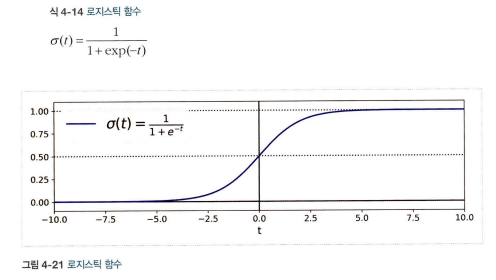

###**4.6.2 훈련과 비용 함수**
- 훈련의 목적은 양성 샘플(1)에 대해서는 높은 확률로 추정하고 음성 샘플(0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 theta 를 찾는 것
- 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것
  - **로그 손실**
  - 이 비용 함수의 최솟값을 계산하는 알려진 해는 없음
  - 하지만 볼록 함수이므로 경사 하강법이 전역 최솟값을 찾는 것을 보장

<br>

###**4.6.3 결정 경계**
- 로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋 사용
  - 세 개의 품종에 속하는 붓꽃 150개의 꽃잎, 꽃받침의 너비와 길이를 담고 있음
- 꽃잎의 너비를 기반으로 Iris-Versicolor 종을 감지하는 분류기 만들기

In [38]:
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [39]:
X=iris['data'][:,3:]
y=(iris['target']==2).astype(np.int)

<ipython-input-39-6e5e4255692a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=(iris['target']==2).astype(np.int)


In [40]:
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

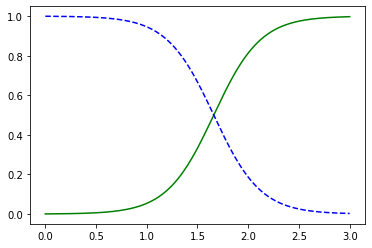

In [41]:
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:,0], 'b--', label='Not Iris virginica')

- 꽃잎 너비 2cm 이상인 꽃은 분류기가 Iris-Verginica라고 강하게 확신
- 1cm 아래면 Iris-Verginica가 아니라고 강하게 확신

In [42]:
 log_reg.predict([[1.7],[1.5]])

array([1, 0])

 - 다른 선형 모델처럼 로지스틱 회귀 모델도 l1, l2 페널티를 사용하여 규제할 수 있음
 - 사이킷런은 l2 페널티를 기본으로 함

 <br>

###**4.6.4 소프트맥스 회귀**

**소프트맥스 회귀 (다항 로지스틱 회귀)**
- 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화
- 샘플 x가 주어지면 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 sk(x)를 계산하고 그 점수에 소프트 맥스 함수를 적용하여 각 클래스의 확률을 추정
- 각 클래스는 자신만의 파라미터 벡터 theta(k)가 존재: 파라미터 행렬에 행으로 저장
- 점수가 계산되면 소프트맥스 함수를 통과시켜 클래스 k에 속할 확률 p(k)를 추정 가능

<br>

- 로지스틱 회귀 분류기와 마찬가지로 소프트 맥스 회귀 분류기는 추정 확률이 가장 높은 클래스를 선택

- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 하는 것이 목적
: **크로스 엔트로피** 비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 부함

<br>

- 사이킷런의 Logistic Regression은 클래스가 둘 이상일 때 기본적으로 일대다(OvA) 전략 사용
- 소프트 맥스 회귀를 사용해 붓꽃을 세개의 클래스로 분류

In [43]:
X=iris['data'][:,(2,3)]
y=iris['target']

softmax_reg=LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X,y)

print(softmax_reg.predict([[5,2]]))
print(softmax_reg.predict_proba([[5,2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
